- Plan to train each column separately.
- Here, use an rnn model to train the first column: `toxic`
- It is pretty slow

In [1]:
## system
import os

## Math and dataFrame
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, hstack

## Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

In [2]:
## Traditional Machine Learning
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

In [3]:
## Keras
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping#, TensorBoard
from keras import backend as K
from keras import optimizers
from keras.optimizers import SGD
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [4]:
## Using Multi processing

In [5]:
from multiprocessing import Pool

In [6]:
## Load data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

##### Do some statistics

In [7]:
display(train[:10])
print(train.shape)
print("toxic count = {0}".format(train.toxic.sum()))
print("severe_toxic count = {0}".format(train.severe_toxic.sum()))
print("obscene count = {0}".format(train.obscene.sum()))
print("threat count = {0}".format(train.threat.sum()))
print("insult count = {0}".format(train.insult.sum()))
print("identity_hate count = {0}".format(train.identity_hate.sum()))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


(159571, 8)
toxic count = 15294
severe_toxic count = 1595
obscene count = 8449
threat count = 478
insult count = 7877
identity_hate count = 1405


###### Show correlation matrix

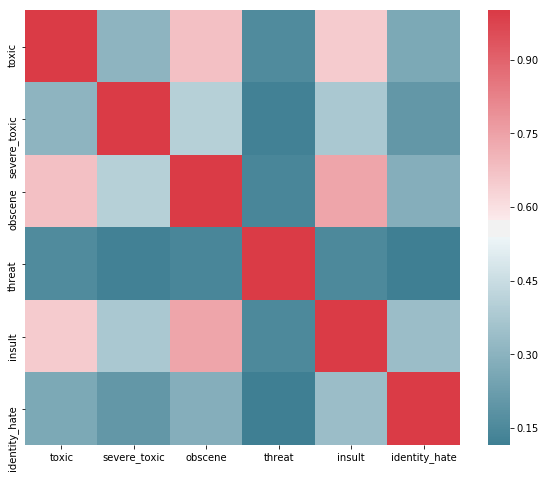

In [8]:
corr = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

###### For Sentence processing

In [9]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)

Here I am trying to remove all the stop words and punctuations. Not sure whether it will give a better result or not

In [10]:
#### Preprocess sentences (removing punctuations and removing stop words)
def rmPunc(sent):
    return ''.join([ch for ch in str(sent) if ch not in punc])
def rmStop(sent):
    return ' '.join([word for word in sent.split() if word not in stop])

In [11]:
print("PREPROCESS TEXT...")
pool = Pool()
%time train.comment_text = pool.map(rmPunc, train.comment_text.str.lower())
%time test.comment_text = pool.map(rmPunc, test.comment_text.str.lower())

%time train.comment_text = pool.map(rmStop, train.comment_text.str.lower())
%time test.comment_text = pool.map(rmStop, test.comment_text.str.lower())
pool.close()
pool.join()

PREPROCESS TEXT...
CPU times: user 420 ms, sys: 348 ms, total: 768 ms
Wall time: 1.7 s
CPU times: user 432 ms, sys: 272 ms, total: 704 ms
Wall time: 1.42 s
CPU times: user 444 ms, sys: 184 ms, total: 628 ms
Wall time: 882 ms
CPU times: user 440 ms, sys: 108 ms, total: 548 ms
Wall time: 797 ms


###### Tokenization

In [12]:
#PROCESS TEXT: RAW
print("Text to seq process...")
print("   Fitting tokenizer...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.comment_text.str.lower(), 
                      test.comment_text.str.lower()])
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")
train["input"] = tok_raw.texts_to_sequences(train.comment_text.str.lower())
test["input"] = tok_raw.texts_to_sequences(test.comment_text.str.lower())

Text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


###### Some statistics on sentence lengths

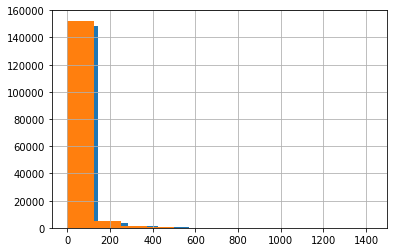

In [13]:
test.input.apply(lambda x: len(x)).hist()
train.input.apply(lambda x: len(x)).hist()

In [14]:
MAX_LENGTH = 200
MAX_TOKEN = np.max([np.max(train.input.max()),np.max(test.input.max())]) + 5
print(MAX_LENGTH, MAX_TOKEN)

200 475107


In [15]:
train = train[['input', 'toxic']]
dtrain, dvalid = train_test_split(train, random_state=17, train_size=0.7)
print(dtrain.shape)
print(dvalid.shape)

(111699, 2)
(47872, 2)


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


###### Artificially balance the classes

In [16]:
L = len(dtrain)
df_irr = dtrain[dtrain.toxic != 0]
while len(dtrain) < 2*L:
    dtrain = dtrain.append(df_irr, ignore_index=True)

In [17]:
L = len(dvalid)
df_irr = dvalid[dvalid.toxic != 0]
while len(dvalid) < 2*L:
    dvalid = dvalid.append(df_irr, ignore_index=True)

###### Creating RNN model

In [18]:
A = Input(shape=[MAX_LENGTH], name="in")
B = Embedding(MAX_TOKEN, 128)(A)
C = GRU(32) (B)
D = Dropout(0.6) (Dense(128, activation='relu') (C))
E = Dropout(0.4) (Dense(32, activation='relu') (D))
output = Dense(2, activation="softmax") (E)

In [19]:
model = Model(A, output)
N_epoch = 1
learning_rate = 0.05
optimizer = SGD(learning_rate)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          60813696  
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                15456     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

In [20]:
train_x = pad_sequences(dtrain.input, maxlen=MAX_LENGTH)
valid_x = pad_sequences(dvalid.input, maxlen=MAX_LENGTH)
train_y = np_utils.to_categorical(dtrain.toxic.values, 2)
valid_y = np_utils.to_categorical(dvalid.toxic.values, 2)

In [21]:
res = model.fit(train_x, train_y, batch_size = 128, epochs = N_epoch, 
                verbose = 1, validation_data = (valid_x, valid_y))

Train on 229509 samples, validate on 98296 samples
Epoch 1/1
229509/229509 [==============================] - 1600s 7ms/step - loss: 0.5985 - acc: 0.6551 - val_loss: 0.3845 - val_acc: 0.8291
